In [1]:
import math
import random
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm

import numpy as np
import numba
import numpy.random
from collections import deque

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, Reshape
from tensorflow.keras.optimizers import Adam

In [2]:
class GridWorld:
    def __init__(self, taille, position_start, good_end_position, bad_end_position):
        self.current_state = position_start  # État actuel (ligne, colonne)
        self.states = [[x, y] for x in range(taille[0]) for y in range(taille[1])]
        self.end_good_state = good_end_position  # État final (ligne, colonne)
        self.end_bad_state = bad_end_position
        self.grid_size = taille  # Taille de la grille (lignes, colonnes)
        self.stateSpace = {}
        self.matchStates()
        self.currentIntState = self.getStateInt(self.current_state)
        self.num_actions = 4  # Nombre total d'actions possibles (haut, bas, gauche, droite)
        self.reward = 0  # Récompense actuelle
        self.done = False  # Indique si la partie est terminée
        self.generate_grid()
        self.actions = [0, 1, 2, 3]
        self.rewards = [0, 1, 3]
        self.actionSpace = {0: -self.grid_size[0], 1: self.grid_size[0],
                            2: -1, 3: 1}

    
    def reset(self):
        self.done = False
        self.current_state = [np.random.randint(0,self.grid_size[0]-1), np.random.randint(0,self.grid_size[1]-1)]
        self.currentIntState = self.getStateInt(self.current_state)
        self.reward = 0
        
    def state_description(self):
        return self.currentIntState / (len(self.states) - 1) * 2.0 - 1.0
        
    def matchStates(self):
        i=0
        for s in self.states:
            self.stateSpace[str(s)] = i
            i = i+1
    
    def getStateInt(self, st):
        return self.stateSpace[str(st)]
    
    def getStateCouple(self, st):
        n_state = {i for i in self.stateSpace if self.stateSpace[i]==st}
        return list(n_state)
        
    
    def step(self, action):
        if action == 0:
            if self.current_state[0] == 0 :
                self.current_state[0] = self.grid_size[0] - 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = -1  # Pas de récompense pour traverser le mur
                self.generate_grid()
                self.endgame()
            else:
                self.current_state[0] = self.current_state[0] - 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = -1  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()

        elif action == 1:
            if self.current_state[0] == self.grid_size[0] - 1:
                self.current_state[0] = 0
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = -1  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()
            else :
                self.current_state[0] = self.current_state[0] + 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = -1  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()

        elif action == 2:
            if self.current_state[1] == 0:
                self.current_state[1] = self.grid_size[1] - 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = -1  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()
            else:
                self.current_state[1] = self.current_state[1] - 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = -1  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()

        elif action == 3:
            if self.current_state[1] == self.grid_size[1] - 1:
                self.current_state[1] = 0
                self.currentIntState = self.getStateInt(self.current_state)
                #print(self.current_state)
                self.reward = -1  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()
            else:
                self.current_state[1] = self.current_state[1] + 1
                self.currentIntState = self.getStateInt(self.current_state)
                self.reward = -1  # Pas de récompense pour avancer
                self.generate_grid()
                self.endgame()
                # Si l'on atteint l'état final, la partie est terminée
        return self.currentIntState, self.reward, self.done

    def endgame(self):
        if self.current_state == self.end_good_state:
            self.reward = 10  # Récompense de 1 pour atteindre l'état final
            self.done = True
        elif self.current_state == self.end_bad_state:
            self.reward = -10
            self.done = True

    # def update_grid(self):
    #     new_grid = [["_", "_", "_", "_"],
    #                 ["_", "_", "_", "_"],
    #                 ["_", "_", "_", "_"],
    #                 ["_", "_", "_", "_"]]
    #     new_grid[self.current_state[0]][self.current_state[1]] = "X"
    #     for i in new_grid:
    #         print(i)

    def generate_grid(self):
        grid=[]
        for i in range(self.grid_size[0]):
            grid.append([])
            for j in range(self.grid_size[1]):
                grid[i].append("_")
        grid[self.current_state[0]][self.current_state[1]] = "X"
        for i in grid:
            print(i)
        print("\n")
    

In [3]:
def REINFORCE_with_mean_baseline(env, max_iter_count: int = 10000,
                                  gamma: float = 0.99,
                                  alpha_pi: float = 0.01,
                                  alpha_v: float = 0.01):
    pi = tf.keras.models.Sequential()
    pi.add(tf.keras.layers.Dense(len(env.actions),
                                 activation=tf.keras.activations.softmax,
                                 use_bias=True
                                 ))


    ema_score = 0.0
    ema_nb_steps = 0.0
    first_episode = True

    step = 0
    ema_score_progress = []
    ema_nb_steps_progress = []

    episode_states_buffer = []
    episode_actions_buffer = []
    episode_rewards_buffer = []
    
    mean_baseline = 0.0

    for _ in tqdm(range(max_iter_count)):
        if env.done:
            ### TRAINING TIME !!!
            G = 0.0

            for t in reversed(range(0, len(episode_states_buffer))):
                G = episode_rewards_buffer[t] + gamma * G

                delta = G - mean_baseline
                

                with tf.GradientTape() as tape_pi:
                    pi_s_a_t = pi(np.array([episode_states_buffer[t]]))[0][episode_actions_buffer[t]]
                    log_pi_s_a_t = tf.math.log(pi_s_a_t)

                grads = tape_pi.gradient(log_pi_s_a_t, pi.trainable_variables)

                for (var, grad) in zip(pi.trainable_variables, grads):
                    if grad is not None:
                        var.assign_add(alpha_pi * (gamma ** t) * delta * grad)

            mean_baseline = ((mean_baseline * step) + G) / (step + 1)
            
            if first_episode:
                ema_score = env.reward
                ema_nb_steps = step
                first_episode = False
            else:
                ema_score = (1 - 0.95) * env.reward + 0.95 * ema_score
                ema_nb_steps = (1 - 0.95) * step + 0.95 * ema_nb_steps
                ema_score_progress.append(ema_score)
                ema_nb_steps_progress.append(ema_nb_steps)

            env.reset()
            episode_states_buffer.clear()
            episode_actions_buffer.clear()
            episode_rewards_buffer.clear()
            step = 0

        s = np.array([env.state_description()])

        episode_states_buffer.append(s)

        aa = env.actions

        pi_s = pi(np.array([s]))[0].numpy()
        allowed_pi_s = pi_s[aa]
        sum_allowed_pi_s = np.sum(allowed_pi_s)
        if sum_allowed_pi_s == 0.0:
            probs = np.ones((len(aa),)) * 1.0 / (len(aa))
        else:
            probs = allowed_pi_s / sum_allowed_pi_s

        a = np.random.choice(aa, p=probs)

        episode_actions_buffer.append(a)

        old_score = env.reward
        env.step(a)
        new_score = env.reward
        r = new_score - old_score

        episode_rewards_buffer.append(r)

        step += 1
    return pi, mean_baseline, ema_score_progress, ema_nb_steps_progress


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




  0%|                                                                              | 13/10000 [00:00<01:23, 119.89it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

  0%|▏                                                                              | 25/10000 [00:00<02:46, 60.07it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '

  0%|▎                                                                              | 47/10000 [00:00<02:00, 82.48it/s]

['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '

  1%|▌                                                                             | 77/10000 [00:00<01:25, 115.80it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '

  1%|▋                                                                              | 90/10000 [00:01<03:42, 44.53it/s]

['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '

  1%|▊                                                                             | 100/10000 [00:01<03:31, 46.77it/s]

['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '

  1%|▉                                                                             | 117/10000 [00:02<03:26, 47.76it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

  1%|█                                                                             | 129/10000 [00:02<03:12, 51.25it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

  1%|█                                                                             | 136/10000 [00:02<03:06, 52.92it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '

  1%|█▏                                                                            | 148/10000 [00:02<02:30, 65.64it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




  2%|█▎                                                                            | 172/10000 [00:02<02:22, 69.00it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

  2%|█▍                                                                            | 188/10000 [00:02<01:53, 86.71it/s]


['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['X', '_', '_', '_']
['_', '_'

  2%|█▌                                                                            | 199/10000 [00:03<03:26, 47.42it/s]

['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

  2%|█▋                                                                            | 222/10000 [00:03<02:46, 58.69it/s]

['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

  2%|█▉                                                                            | 249/10000 [00:03<01:55, 84.33it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '

  3%|██                                                                            | 261/10000 [00:04<03:48, 42.56it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

  3%|██                                                                            | 270/10000 [00:04<03:43, 43.59it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']

  3%|██▏                                                                           | 278/10000 [00:04<03:24, 47.47it/s]


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', 

  3%|██▎                                                                           | 302/10000 [00:05<02:35, 62.55it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

  3%|██▌                                                                           | 331/10000 [00:05<01:45, 91.66it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

  3%|██▋                                                                          | 346/10000 [00:05<01:33, 103.36it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

  4%|██▉                                                                           | 375/10000 [00:06<02:51, 56.18it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

  4%|███▏                                                                          | 404/10000 [00:06<02:46, 57.56it/s]

['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

  4%|███▎                                                                          | 432/10000 [00:07<01:59, 79.87it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

  4%|███▍                                                                          | 444/10000 [00:07<03:35, 44.29it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

  5%|███▋                                                                          | 466/10000 [00:08<03:00, 52.89it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

  5%|███▊                                                                          | 494/10000 [00:08<01:59, 79.66it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

  5%|███▉                                                                          | 507/10000 [00:08<01:47, 88.29it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




  5%|████                                                                          | 519/10000 [00:09<03:55, 40.25it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




  5%|████▏                                                                         | 537/10000 [00:09<03:21, 47.07it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '

  6%|████▍                                                                         | 565/10000 [00:09<02:30, 62.66it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

  6%|████▍                                                                         | 575/10000 [00:10<03:15, 48.33it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

  6%|████▌                                                                         | 586/10000 [00:10<03:04, 51.05it/s]

['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

  6%|████▋                                                                         | 608/10000 [00:10<02:54, 53.85it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

  6%|████▉                                                                         | 630/10000 [00:11<02:14, 69.64it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

  6%|████▉                                                                         | 639/10000 [00:11<02:50, 54.75it/s]

['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

  7%|█████▏                                                                        | 668/10000 [00:11<02:15, 69.10it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

  7%|█████▍                                                                        | 694/10000 [00:12<02:18, 67.34it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '

  7%|█████▍                                                                        | 704/10000 [00:12<02:47, 55.59it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '

  7%|█████▋                                                                        | 733/10000 [00:12<01:51, 83.31it/s]

['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '

  8%|█████▉                                                                        | 760/10000 [00:12<01:35, 97.09it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

  8%|█████▉                                                                       | 772/10000 [00:12<01:30, 102.32it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '

  8%|██████                                                                        | 784/10000 [00:14<05:06, 30.06it/s]

['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

  8%|██████▏                                                                       | 796/10000 [00:14<04:34, 33.53it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

  8%|██████▍                                                                       | 825/10000 [00:14<03:10, 48.16it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

  8%|██████▌                                                                       | 834/10000 [00:15<03:39, 41.81it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

  8%|██████▌                                                                       | 845/10000 [00:15<03:35, 42.55it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

  9%|██████▊                                                                       | 879/10000 [00:15<02:23, 63.75it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '

  9%|██████▉                                                                       | 890/10000 [00:15<02:08, 70.81it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




  9%|███████                                                                       | 911/10000 [00:16<02:51, 52.86it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '

  9%|███████▏                                                                      | 925/10000 [00:16<02:16, 66.34it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 10%|███████▍                                                                      | 951/10000 [00:16<01:42, 87.97it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 10%|███████▌                                                                     | 981/10000 [00:16<01:20, 112.15it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 10%|███████▋                                                                    | 1009/10000 [00:17<01:16, 118.22it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 10%|███████▉                                                                    | 1037/10000 [00:17<01:11, 125.41it/s]

['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 10%|███████▉                                                                    | 1050/10000 [00:17<01:12, 122.88it/s]

['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 11%|████████                                                                    | 1064/10000 [00:17<01:11, 124.90it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 11%|████████▎                                                                    | 1077/10000 [00:19<06:56, 21.44it/s]

['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '

 11%|████████▍                                                                    | 1090/10000 [00:19<05:41, 26.10it/s]




['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']




 11%|████████▍                                                                    | 1101/10000 [00:19<04:34, 32.45it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 11%|████████▋                                                                    | 1123/10000 [00:20<03:38, 40.72it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '

 11%|████████▊                                                                    | 1138/10000 [00:20<02:43, 54.33it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 12%|████████▉                                                                    | 1156/10000 [00:20<03:16, 45.09it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '

 12%|█████████                                                                    | 1169/10000 [00:20<02:55, 50.38it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']




 12%|█████████                                                                    | 1180/10000 [00:21<02:44, 53.66it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 12%|█████████▏                                                                   | 1199/10000 [00:21<02:15, 65.02it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 12%|█████████▍                                                                   | 1222/10000 [00:21<01:53, 77.36it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 12%|█████████▌                                                                   | 1240/10000 [00:22<02:48, 51.89it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 12%|█████████▌                                                                   | 1248/10000 [00:22<02:56, 49.51it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']




 13%|█████████▋                                                                   | 1259/10000 [00:22<02:55, 49.92it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']


 13%|█████████▋                                                                   | 1265/10000 [00:22<02:53, 50.30it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 13%|█████████▉                                                                   | 1286/10000 [00:22<02:05, 69.23it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 13%|█████████▉                                                                   | 1298/10000 [00:23<01:48, 80.51it/s]


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 13%|██████████                                                                   | 1308/10000 [00:23<03:02, 47.63it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '

 13%|██████████▏                                                                  | 1316/10000 [00:23<02:56, 49.17it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 13%|██████████▎                                                                  | 1344/10000 [00:23<02:18, 62.30it/s]

['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 14%|██████████▍                                                                  | 1353/10000 [00:24<02:47, 51.57it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 14%|██████████▌                                                                  | 1370/10000 [00:24<02:47, 51.57it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 14%|██████████▋                                                                  | 1388/10000 [00:24<02:23, 60.05it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 14%|██████████▉                                                                  | 1414/10000 [00:25<01:40, 85.74it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 14%|██████████▉                                                                  | 1424/10000 [00:25<02:39, 53.92it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 14%|███████████                                                                  | 1442/10000 [00:25<02:35, 55.14it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 15%|███████████▏                                                                 | 1461/10000 [00:26<02:05, 67.91it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 15%|███████████▎                                                                 | 1470/10000 [00:26<02:47, 50.80it/s]

['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 15%|███████████▌                                                                 | 1499/10000 [00:26<02:06, 67.26it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '

 15%|███████████▋                                                                 | 1514/10000 [00:26<01:42, 82.93it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']




 15%|███████████▊                                                                 | 1534/10000 [00:27<02:47, 50.55it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 16%|███████████▉                                                                 | 1557/10000 [00:27<02:21, 59.57it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 16%|████████████                                                                 | 1573/10000 [00:28<03:03, 45.85it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '

 16%|████████████▎                                                                | 1592/10000 [00:28<02:52, 48.72it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 16%|████████████▎                                                                | 1602/10000 [00:28<02:48, 49.83it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']




 16%|████████████▍                                                                | 1614/10000 [00:28<02:14, 62.52it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 16%|████████████▍                                                                | 1622/10000 [00:29<02:47, 49.92it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']




 16%|████████████▌                                                                | 1636/10000 [00:29<02:50, 49.10it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 16%|████████████▋                                                                | 1650/10000 [00:29<02:34, 54.11it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 17%|████████████▊                                                                | 1663/10000 [00:29<01:56, 71.41it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 17%|████████████▊                                                                | 1672/10000 [00:30<03:03, 45.26it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 17%|████████████▉                                                                | 1685/10000 [00:30<03:21, 41.29it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 17%|█████████████▏                                                               | 1709/10000 [00:30<01:57, 70.82it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 17%|█████████████▏                                                               | 1718/10000 [00:31<03:19, 41.42it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['X', '_', '_', '_']
['_', '_', '_', '_']

 17%|█████████████▎                                                               | 1735/10000 [00:31<02:57, 46.65it/s]


['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_'

 17%|█████████████▍                                                               | 1746/10000 [00:31<02:48, 49.12it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 18%|█████████████▌                                                               | 1758/10000 [00:32<02:49, 48.67it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']




 18%|█████████████▌                                                               | 1766/10000 [00:32<02:46, 49.32it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']




 18%|█████████████▋                                                               | 1778/10000 [00:32<02:41, 50.76it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 18%|█████████████▊                                                               | 1791/10000 [00:32<02:00, 68.26it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']




 18%|█████████████▊                                                               | 1799/10000 [00:32<02:40, 50.99it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']




 18%|█████████████▉                                                               | 1806/10000 [00:32<02:49, 48.40it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 18%|█████████████▉                                                               | 1818/10000 [00:33<02:42, 50.26it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 18%|██████████████▏                                                              | 1842/10000 [00:33<02:13, 61.11it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 18%|██████████████▏                                                              | 1849/10000 [00:33<02:32, 53.40it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 19%|██████████████▍                                                              | 1868/10000 [00:34<02:39, 51.09it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 19%|██████████████▌                                                              | 1899/10000 [00:34<01:31, 88.86it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 19%|██████████████▋                                                              | 1910/10000 [00:34<01:26, 93.70it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 19%|██████████████▊                                                              | 1921/10000 [00:35<03:09, 42.59it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 19%|██████████████▉                                                              | 1941/10000 [00:35<02:52, 46.82it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 20%|███████████████                                                              | 1963/10000 [00:35<02:15, 59.20it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 20%|███████████████▏                                                             | 1973/10000 [00:35<02:39, 50.22it/s]




['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']




 20%|███████████████▎                                                             | 1989/10000 [00:36<01:57, 67.92it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 20%|███████████████▍                                                             | 2010/10000 [00:36<02:30, 53.24it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 20%|███████████████▌                                                             | 2017/10000 [00:36<02:44, 48.46it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']




 20%|███████████████▌                                                             | 2025/10000 [00:36<02:37, 50.51it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 20%|███████████████▋                                                             | 2038/10000 [00:37<02:03, 64.48it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


 20%|███████████████▊                                                             | 2046/10000 [00:37<02:50, 46.58it/s]



['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']




 21%|███████████████▊                                                             | 2053/10000 [00:37<02:44, 48.44it/s]

['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']




 21%|███████████████▊                                                             | 2061/10000 [00:37<02:26, 54.37it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 21%|████████████████                                                             | 2083/10000 [00:38<02:36, 50.53it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']




 21%|████████████████                                                             | 2089/10000 [00:38<02:43, 48.36it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']




 21%|████████████████▏                                                            | 2100/10000 [00:38<02:12, 59.71it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 21%|████████████████▏                                                            | 2107/10000 [00:38<02:40, 49.20it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 21%|████████████████▍                                                            | 2135/10000 [00:39<02:42, 48.45it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']




 21%|████████████████▌                                                            | 2144/10000 [00:39<02:29, 52.51it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']




 22%|████████████████▋                                                            | 2163/10000 [00:39<02:00, 65.10it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 22%|████████████████▋                                                            | 2171/10000 [00:39<02:34, 50.73it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 22%|████████████████▊                                                            | 2191/10000 [00:40<02:38, 49.16it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']




 22%|████████████████▉                                                            | 2206/10000 [00:40<01:57, 66.29it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 22%|█████████████████                                                            | 2214/10000 [00:40<02:51, 45.33it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']




 22%|█████████████████▏                                                           | 2234/10000 [00:40<02:09, 60.18it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 22%|█████████████████▎                                                           | 2249/10000 [00:41<02:27, 52.55it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '

 23%|█████████████████▍                                                           | 2262/10000 [00:41<01:53, 68.10it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 23%|█████████████████▍                                                           | 2271/10000 [00:41<02:35, 49.83it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 23%|█████████████████▌                                                           | 2279/10000 [00:41<02:43, 47.25it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 23%|█████████████████▊                                                           | 2308/10000 [00:42<01:48, 70.61it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 23%|█████████████████▉                                                           | 2325/10000 [00:42<02:38, 48.38it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 23%|██████████████████                                                           | 2343/10000 [00:42<02:23, 53.41it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 24%|██████████████████▏                                                          | 2361/10000 [00:43<02:19, 54.89it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 24%|██████████████████▎                                                          | 2374/10000 [00:43<02:16, 56.06it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 24%|██████████████████▍                                                          | 2392/10000 [00:43<02:19, 54.54it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']




 24%|██████████████████▍                                                          | 2399/10000 [00:43<02:18, 54.74it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 24%|██████████████████▌                                                          | 2414/10000 [00:44<01:40, 75.35it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']




 24%|██████████████████▊                                                          | 2439/10000 [00:44<01:29, 84.57it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 25%|██████████████████▉                                                          | 2457/10000 [00:44<02:23, 52.58it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 25%|██████████████████▉                                                          | 2467/10000 [00:45<02:03, 61.12it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 25%|███████████████████                                                          | 2475/10000 [00:45<02:14, 55.95it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 25%|███████████████████▏                                                         | 2489/10000 [00:45<02:14, 55.91it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 25%|███████████████████▎                                                         | 2504/10000 [00:45<02:11, 57.07it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 25%|███████████████████▍                                                         | 2530/10000 [00:45<01:25, 87.26it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 25%|███████████████████▌                                                         | 2540/10000 [00:46<02:11, 56.68it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 25%|███████████████████▌                                                         | 2548/10000 [00:46<02:24, 51.75it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 26%|███████████████████▊                                                         | 2573/10000 [00:46<01:49, 67.91it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 26%|████████████████████                                                         | 2598/10000 [00:47<01:36, 76.96it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 26%|███████████████████▉                                                        | 2628/10000 [00:47<01:10, 104.48it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 27%|████████████████████▍                                                        | 2656/10000 [00:48<02:12, 55.34it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 27%|████████████████████▌                                                        | 2667/10000 [00:48<01:56, 63.01it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 27%|████████████████████▋                                                        | 2687/10000 [00:48<02:36, 46.58it/s]

['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 27%|████████████████████▉                                                        | 2722/10000 [00:49<01:27, 83.53it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 27%|█████████████████████                                                        | 2735/10000 [00:49<02:37, 46.18it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']




 28%|█████████████████████▏                                                       | 2759/10000 [00:49<02:01, 59.69it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 28%|█████████████████████▎                                                       | 2769/10000 [00:50<02:33, 46.96it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '

 28%|█████████████████████▍                                                       | 2787/10000 [00:50<02:12, 54.38it/s]




['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X'

 28%|█████████████████████▌                                                       | 2801/10000 [00:51<02:54, 41.34it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 28%|█████████████████████▋                                                       | 2815/10000 [00:51<02:04, 57.80it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 28%|█████████████████████▋                                                       | 2824/10000 [00:51<02:42, 44.18it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 28%|█████████████████████▉                                                       | 2846/10000 [00:51<02:01, 58.71it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 29%|██████████████████████                                                       | 2865/10000 [00:52<02:45, 43.07it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 29%|██████████████████████▏                                                      | 2876/10000 [00:52<02:40, 44.42it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 29%|██████████████████████▎                                                      | 2897/10000 [00:53<02:32, 46.55it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']




 29%|██████████████████████▍                                                      | 2910/10000 [00:53<01:58, 59.87it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 29%|██████████████████████▍                                                      | 2918/10000 [00:53<02:34, 45.92it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 29%|██████████████████████▌                                                      | 2933/10000 [00:53<02:26, 48.35it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 29%|██████████████████████▋                                                      | 2943/10000 [00:53<02:01, 58.10it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 30%|██████████████████████▊                                                      | 2956/10000 [00:54<02:21, 49.63it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 30%|██████████████████████▊                                                      | 2965/10000 [00:54<02:24, 48.78it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']




 30%|██████████████████████▉                                                      | 2979/10000 [00:54<02:08, 54.43it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']




 30%|██████████████████████▉                                                      | 2986/10000 [00:54<02:17, 50.85it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']




 30%|███████████████████████▏                                                     | 3013/10000 [00:55<01:25, 82.05it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 30%|███████████████████████▎                                                     | 3023/10000 [00:55<02:22, 48.95it/s]

['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 30%|███████████████████████▍                                                     | 3045/10000 [00:55<01:46, 65.44it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 31%|███████████████████████▌                                                     | 3060/10000 [00:55<01:24, 82.13it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 31%|███████████████████████▋                                                     | 3081/10000 [00:56<02:22, 48.50it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 31%|███████████████████████▊                                                     | 3100/10000 [00:56<02:15, 50.98it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '

 31%|████████████████████████                                                     | 3124/10000 [00:57<01:31, 74.95it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 31%|████████████████████████▏                                                    | 3134/10000 [00:57<02:18, 49.67it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']




 32%|████████████████████████▎                                                    | 3151/10000 [00:57<02:14, 51.10it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 32%|████████████████████████▎                                                    | 3162/10000 [00:57<02:09, 52.68it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']




 32%|████████████████████████▍                                                    | 3170/10000 [00:58<02:06, 53.92it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 32%|████████████████████████▌                                                    | 3182/10000 [00:58<01:43, 65.89it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 32%|████████████████████████▋                                                    | 3208/10000 [00:58<01:32, 73.62it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 32%|████████████████████████▉                                                    | 3233/10000 [00:59<01:41, 66.61it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 32%|████████████████████████▉                                                    | 3244/10000 [00:59<02:10, 51.71it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 33%|█████████████████████████▏                                                   | 3266/10000 [00:59<01:56, 57.97it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 33%|█████████████████████████▏                                                   | 3277/10000 [00:59<01:56, 57.91it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']




 33%|█████████████████████████▎                                                   | 3288/10000 [01:00<02:02, 54.71it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']




 33%|█████████████████████████▍                                                   | 3299/10000 [01:00<02:00, 55.69it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']




 33%|█████████████████████████▌                                                   | 3316/10000 [01:00<01:29, 75.06it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 33%|█████████████████████████▋                                                   | 3334/10000 [01:00<02:02, 54.60it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 33%|█████████████████████████▊                                                   | 3348/10000 [01:01<01:55, 57.45it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']




 34%|█████████████████████████▉                                                   | 3363/10000 [01:01<01:30, 73.33it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 34%|█████████████████████████▉                                                   | 3373/10000 [01:01<01:51, 59.57it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '

 34%|██████████████████████████▏                                                  | 3397/10000 [01:01<01:26, 76.08it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 34%|██████████████████████████▏                                                  | 3407/10000 [01:02<01:55, 57.26it/s]

['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 34%|██████████████████████████▎                                                  | 3422/10000 [01:02<02:03, 53.13it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 34%|██████████████████████████▍                                                  | 3435/10000 [01:02<01:54, 57.47it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 34%|██████████████████████████▌                                                  | 3446/10000 [01:02<01:38, 66.82it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 35%|██████████████████████████▋                                                  | 3461/10000 [01:03<01:57, 55.53it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 35%|██████████████████████████▉                                                  | 3493/10000 [01:03<01:08, 94.93it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 35%|██████████████████████████▉                                                  | 3504/10000 [01:03<02:10, 49.90it/s]

['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 35%|███████████████████████████▏                                                 | 3523/10000 [01:04<01:57, 55.20it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 35%|███████████████████████████▏                                                 | 3538/10000 [01:04<01:52, 57.40it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 35%|███████████████████████████▎                                                 | 3545/10000 [01:04<01:48, 59.33it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 36%|███████████████████████████▍                                                 | 3567/10000 [01:04<01:52, 57.25it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 36%|███████████████████████████▌                                                 | 3578/10000 [01:04<01:48, 59.25it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 36%|███████████████████████████▌                                                 | 3586/10000 [01:05<01:46, 60.28it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 36%|███████████████████████████▊                                                 | 3610/10000 [01:05<01:19, 79.88it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 36%|███████████████████████████▊                                                 | 3619/10000 [01:05<01:46, 60.01it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 36%|███████████████████████████▉                                                 | 3635/10000 [01:05<01:43, 61.26it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 36%|████████████████████████████                                                 | 3649/10000 [01:06<01:51, 57.11it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 37%|████████████████████████████▏                                                | 3660/10000 [01:06<01:31, 69.25it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']




 37%|████████████████████████████▎                                                | 3675/10000 [01:06<01:43, 60.84it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 37%|████████████████████████████▍                                                | 3687/10000 [01:06<01:43, 61.22it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']




 37%|████████████████████████████▌                                                | 3703/10000 [01:06<01:42, 61.22it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']




 37%|████████████████████████████▌                                                | 3710/10000 [01:07<01:47, 58.58it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']




 37%|████████████████████████████▌                                                | 3717/10000 [01:07<01:42, 61.07it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']




 37%|████████████████████████████▋                                                | 3724/10000 [01:07<02:03, 50.65it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 37%|████████████████████████████▊                                                | 3743/10000 [01:07<02:04, 50.32it/s]

['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']




 37%|████████████████████████████▊                                                | 3749/10000 [01:07<02:01, 51.41it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']




 38%|████████████████████████████▉                                                | 3761/10000 [01:08<02:13, 46.89it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']




 38%|█████████████████████████████                                                | 3775/10000 [01:08<01:33, 66.77it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 38%|█████████████████████████████▎                                               | 3799/10000 [01:08<01:53, 54.67it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 38%|█████████████████████████████▎                                               | 3813/10000 [01:09<01:55, 53.38it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 38%|█████████████████████████████▍                                               | 3828/10000 [01:09<02:02, 50.44it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 39%|█████████████████████████████▋                                               | 3853/10000 [01:09<01:16, 80.08it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 39%|█████████████████████████████▋                                               | 3863/10000 [01:10<01:59, 51.20it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']




 39%|█████████████████████████████▊                                               | 3878/10000 [01:10<02:00, 50.79it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 39%|██████████████████████████████                                               | 3905/10000 [01:10<01:33, 65.12it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 39%|██████████████████████████████▏                                              | 3914/10000 [01:10<01:52, 53.96it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 39%|██████████████████████████████▏                                              | 3928/10000 [01:11<01:56, 52.13it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']




 39%|██████████████████████████████▎                                              | 3935/10000 [01:11<01:54, 52.88it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 39%|██████████████████████████████▍                                              | 3949/10000 [01:11<01:50, 54.52it/s]

['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 40%|██████████████████████████████▍                                              | 3959/10000 [01:11<01:50, 54.62it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 40%|██████████████████████████████▌                                              | 3973/10000 [01:11<01:41, 59.38it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 40%|██████████████████████████████▊                                              | 3998/10000 [01:12<01:45, 57.09it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '

 40%|██████████████████████████████▊                                              | 4007/10000 [01:12<01:41, 58.92it/s]


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 

 40%|███████████████████████████████                                              | 4029/10000 [01:12<01:20, 74.44it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 40%|███████████████████████████████▏                                             | 4044/10000 [01:13<01:35, 62.63it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 41%|███████████████████████████████▏                                             | 4051/10000 [01:13<01:45, 56.24it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 41%|███████████████████████████████▎                                             | 4067/10000 [01:13<01:36, 61.29it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 41%|███████████████████████████████▍                                             | 4082/10000 [01:13<01:41, 58.12it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 41%|███████████████████████████████▌                                             | 4103/10000 [01:14<01:16, 76.70it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 41%|███████████████████████████████▋                                             | 4120/10000 [01:14<01:49, 53.81it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 41%|███████████████████████████████▊                                             | 4127/10000 [01:14<01:51, 52.63it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 41%|███████████████████████████████▉                                             | 4144/10000 [01:14<01:45, 55.39it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 42%|███████████████████████████████▉                                             | 4155/10000 [01:15<01:29, 65.66it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 42%|████████████████████████████████▏                                            | 4174/10000 [01:15<01:29, 65.10it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 42%|████████████████████████████████▏                                            | 4182/10000 [01:15<01:50, 52.83it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 42%|████████████████████████████████▎                                            | 4201/10000 [01:15<01:45, 54.91it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 42%|████████████████████████████████▍                                            | 4210/10000 [01:16<01:47, 53.91it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 42%|████████████████████████████████▌                                            | 4224/10000 [01:16<01:38, 58.80it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 42%|████████████████████████████████▋                                            | 4238/10000 [01:16<01:37, 59.09it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 43%|████████████████████████████████▋                                            | 4253/10000 [01:16<01:11, 80.33it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 43%|████████████████████████████████▊                                            | 4262/10000 [01:16<01:46, 53.79it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 43%|████████████████████████████████▉                                            | 4282/10000 [01:17<01:40, 56.99it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 43%|█████████████████████████████████                                            | 4295/10000 [01:17<01:19, 71.38it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 43%|█████████████████████████████████▏                                           | 4311/10000 [01:17<01:45, 54.04it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 43%|█████████████████████████████████▏                                           | 4318/10000 [01:17<01:43, 54.68it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']




 43%|█████████████████████████████████▍                                           | 4341/10000 [01:18<01:15, 75.07it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 44%|█████████████████████████████████▌                                           | 4358/10000 [01:18<01:47, 52.33it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 44%|█████████████████████████████████▌                                           | 4365/10000 [01:18<01:47, 52.38it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 44%|█████████████████████████████████▋                                           | 4380/10000 [01:19<01:50, 51.01it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']




 44%|█████████████████████████████████▊                                           | 4389/10000 [01:19<01:34, 59.19it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 44%|█████████████████████████████████▊                                           | 4397/10000 [01:19<01:47, 52.00it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 44%|██████████████████████████████████                                           | 4422/10000 [01:19<01:29, 62.49it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 44%|██████████████████████████████████▏                                          | 4439/10000 [01:20<01:36, 57.53it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 45%|██████████████████████████████████▎                                          | 4451/10000 [01:20<01:43, 53.83it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']




 45%|██████████████████████████████████▎                                          | 4458/10000 [01:20<01:37, 56.74it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 45%|██████████████████████████████████▍                                          | 4479/10000 [01:20<01:13, 74.65it/s]




['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_'

 45%|██████████████████████████████████▌                                          | 4495/10000 [01:21<01:37, 56.22it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 45%|██████████████████████████████████▋                                          | 4502/10000 [01:21<01:36, 57.12it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 45%|██████████████████████████████████▊                                          | 4518/10000 [01:21<01:09, 78.41it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 45%|██████████████████████████████████▊                                          | 4527/10000 [01:21<01:43, 52.64it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 45%|███████████████████████████████████                                          | 4546/10000 [01:21<01:40, 54.16it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 46%|███████████████████████████████████▏                                         | 4567/10000 [01:22<01:12, 75.19it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 46%|███████████████████████████████████▎                                         | 4582/10000 [01:22<00:58, 92.89it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 46%|███████████████████████████████████▎                                         | 4593/10000 [01:22<01:39, 54.12it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 46%|███████████████████████████████████▌                                         | 4613/10000 [01:23<01:52, 47.93it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '

 46%|███████████████████████████████████▋                                         | 4640/10000 [01:23<01:11, 74.56it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 47%|███████████████████████████████████▉                                         | 4666/10000 [01:23<01:20, 65.96it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 47%|████████████████████████████████████                                         | 4686/10000 [01:24<01:41, 52.10it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 47%|████████████████████████████████████▏                                        | 4707/10000 [01:24<01:30, 58.28it/s]

['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 47%|████████████████████████████████████▎                                        | 4721/10000 [01:24<01:12, 73.13it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 47%|████████████████████████████████████▌                                        | 4742/10000 [01:25<01:50, 47.53it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 48%|████████████████████████████████████▌                                        | 4754/10000 [01:25<01:29, 58.84it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


 48%|████████████████████████████████████▋                                        | 4763/10000 [01:25<01:40, 52.27it/s]



['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_',

 48%|████████████████████████████████████▋                                        | 4771/10000 [01:26<01:36, 54.37it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 48%|████████████████████████████████████▊                                        | 4782/10000 [01:26<01:40, 51.70it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 48%|█████████████████████████████████████                                        | 4808/10000 [01:26<01:16, 67.64it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 48%|█████████████████████████████████████▏                                       | 4828/10000 [01:26<01:31, 56.61it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 48%|█████████████████████████████████████▏                                       | 4837/10000 [01:27<01:35, 53.95it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']




 48%|█████████████████████████████████████▎                                       | 4847/10000 [01:27<01:30, 56.88it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 49%|█████████████████████████████████████▍                                       | 4862/10000 [01:27<01:09, 73.67it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 49%|█████████████████████████████████████▌                                       | 4871/10000 [01:27<01:30, 56.83it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 49%|█████████████████████████████████████▋                                       | 4894/10000 [01:28<01:23, 61.39it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 49%|█████████████████████████████████████▊                                       | 4904/10000 [01:28<01:33, 54.24it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 49%|█████████████████████████████████████▉                                       | 4928/10000 [01:28<01:27, 57.97it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 49%|██████████████████████████████████████                                       | 4942/10000 [01:28<01:34, 53.28it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 49%|██████████████████████████████████████                                       | 4948/10000 [01:29<01:34, 53.56it/s]



['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 50%|██████████████████████████████████████▏                                      | 4964/10000 [01:29<01:36, 52.24it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 50%|██████████████████████████████████████▎                                      | 4980/10000 [01:29<01:23, 60.05it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 50%|██████████████████████████████████████▌                                      | 5002/10000 [01:29<01:01, 81.07it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 50%|██████████████████████████████████████▋                                      | 5018/10000 [01:30<01:51, 44.70it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 50%|██████████████████████████████████████▊                                      | 5034/10000 [01:30<01:31, 54.54it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 50%|██████████████████████████████████████▊                                      | 5047/10000 [01:30<01:43, 47.88it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 51%|██████████████████████████████████████▉                                      | 5053/10000 [01:31<01:44, 47.25it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 51%|██████████████████████████████████████▉                                      | 5059/10000 [01:31<01:48, 45.54it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 51%|███████████████████████████████████████▏                                     | 5085/10000 [01:31<01:16, 64.31it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 51%|███████████████████████████████████████▎                                     | 5112/10000 [01:31<00:53, 91.13it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 51%|███████████████████████████████████████▍                                     | 5122/10000 [01:32<01:47, 45.45it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 51%|███████████████████████████████████████▌                                     | 5137/10000 [01:32<01:50, 44.02it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 52%|███████████████████████████████████████▋                                     | 5161/10000 [01:33<01:26, 56.13it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 52%|███████████████████████████████████████▊                                     | 5177/10000 [01:33<01:31, 52.66it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 52%|███████████████████████████████████████▉                                     | 5194/10000 [01:33<01:33, 51.13it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 52%|████████████████████████████████████████                                     | 5204/10000 [01:33<01:20, 59.75it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 52%|████████████████████████████████████████▏                                    | 5220/10000 [01:34<01:36, 49.63it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 52%|████████████████████████████████████████▎                                    | 5232/10000 [01:34<01:15, 62.84it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 52%|████████████████████████████████████████▎                                    | 5240/10000 [01:34<01:37, 48.62it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 52%|████████████████████████████████████████▍                                    | 5248/10000 [01:34<01:44, 45.57it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 53%|████████████████████████████████████████▌                                    | 5271/10000 [01:35<01:35, 49.52it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 53%|████████████████████████████████████████▋                                    | 5277/10000 [01:35<01:37, 48.42it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 53%|████████████████████████████████████████▊                                    | 5295/10000 [01:35<01:37, 48.04it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 53%|████████████████████████████████████████▉                                    | 5317/10000 [01:36<01:05, 71.72it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_',

 53%|█████████████████████████████████████████                                    | 5326/10000 [01:36<02:03, 37.87it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']




 53%|█████████████████████████████████████████                                    | 5335/10000 [01:36<01:44, 44.80it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']




 53%|█████████████████████████████████████████▏                                   | 5342/10000 [01:36<01:59, 38.97it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 54%|█████████████████████████████████████████▎                                   | 5363/10000 [01:37<01:16, 60.49it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 54%|█████████████████████████████████████████▍                                   | 5374/10000 [01:37<01:06, 69.63it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 54%|█████████████████████████████████████████▌                                   | 5399/10000 [01:38<01:38, 46.70it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 54%|█████████████████████████████████████████▋                                   | 5415/10000 [01:38<01:41, 44.97it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 54%|█████████████████████████████████████████▋                                   | 5422/10000 [01:38<01:41, 45.30it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 54%|█████████████████████████████████████████▊                                   | 5438/10000 [01:38<01:39, 45.86it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 55%|█████████████████████████████████████████▉                                   | 5452/10000 [01:39<01:24, 53.72it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 55%|██████████████████████████████████████████▏                                  | 5472/10000 [01:39<01:28, 50.94it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 55%|██████████████████████████████████████████▏                                  | 5487/10000 [01:39<01:20, 55.83it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 55%|██████████████████████████████████████████▎                                  | 5494/10000 [01:39<01:17, 58.20it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 55%|██████████████████████████████████████████▎                                  | 5501/10000 [01:40<01:31, 49.36it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 55%|██████████████████████████████████████████▍                                  | 5518/10000 [01:40<01:30, 49.57it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']




 55%|██████████████████████████████████████████▌                                  | 5524/10000 [01:40<01:28, 50.73it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 55%|██████████████████████████████████████████▋                                  | 5542/10000 [01:40<01:25, 51.90it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 56%|██████████████████████████████████████████▊                                  | 5564/10000 [01:41<00:57, 76.69it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 56%|██████████████████████████████████████████▉                                  | 5573/10000 [01:41<01:25, 51.90it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 56%|███████████████████████████████████████████                                  | 5587/10000 [01:41<01:04, 68.01it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 56%|███████████████████████████████████████████▏                                 | 5603/10000 [01:41<01:28, 49.83it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 56%|███████████████████████████████████████████▏                                 | 5610/10000 [01:42<01:23, 52.74it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']




 56%|███████████████████████████████████████████▎                                 | 5617/10000 [01:42<01:18, 56.00it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']




 56%|███████████████████████████████████████████▎                                 | 5633/10000 [01:42<01:22, 52.70it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']



 56%|███████████████████████████████████████████▍                                 | 5640/10000 [01:42<01:24, 51.76it/s]


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 

 57%|███████████████████████████████████████████▌                                 | 5661/10000 [01:42<01:09, 62.68it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 57%|███████████████████████████████████████████▋                                 | 5676/10000 [01:43<01:19, 54.24it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 57%|███████████████████████████████████████████▊                                 | 5691/10000 [01:43<01:20, 53.81it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']




 57%|███████████████████████████████████████████▊                                 | 5698/10000 [01:43<01:23, 51.54it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 57%|████████████████████████████████████████████                                 | 5720/10000 [01:43<00:58, 73.73it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 57%|████████████████████████████████████████████▏                                | 5736/10000 [01:44<01:16, 55.38it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 57%|████████████████████████████████████████████▎                                | 5750/10000 [01:44<01:16, 55.86it/s]

['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 58%|████████████████████████████████████████████▎                                | 5759/10000 [01:44<01:07, 63.12it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 58%|████████████████████████████████████████████▍                                | 5774/10000 [01:44<01:17, 54.58it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 58%|████████████████████████████████████████████▌                                | 5786/10000 [01:45<01:21, 51.46it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']

 58%|████████████████████████████████████████████▋                                | 5801/10000 [01:45<01:12, 58.14it/s]


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', 

 58%|████████████████████████████████████████████▋                                | 5808/10000 [01:45<01:28, 47.27it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']




 58%|████████████████████████████████████████████▊                                | 5818/10000 [01:45<01:20, 51.97it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 58%|████████████████████████████████████████████▉                                | 5831/10000 [01:46<01:15, 54.99it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']




 58%|████████████████████████████████████████████▉                                | 5838/10000 [01:46<01:19, 52.20it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']




 59%|█████████████████████████████████████████████                                | 5853/10000 [01:46<00:57, 71.62it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 59%|█████████████████████████████████████████████▏                               | 5862/10000 [01:46<01:13, 56.47it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 59%|█████████████████████████████████████████████▏                               | 5876/10000 [01:46<01:22, 50.22it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 59%|█████████████████████████████████████████████▍                               | 5902/10000 [01:47<01:00, 67.75it/s]


['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_'

 59%|█████████████████████████████████████████████▌                               | 5911/10000 [01:47<01:12, 56.70it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 59%|█████████████████████████████████████████████▌                               | 5923/10000 [01:47<01:14, 55.08it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 59%|█████████████████████████████████████████████▋                               | 5937/10000 [01:47<01:10, 57.34it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 60%|█████████████████████████████████████████████▊                               | 5953/10000 [01:48<01:08, 59.47it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 60%|██████████████████████████████████████████████                               | 5976/10000 [01:48<01:05, 61.40it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 60%|██████████████████████████████████████████████▏                              | 5996/10000 [01:48<01:04, 61.70it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 60%|██████████████████████████████████████████████▏                              | 6004/10000 [01:48<01:05, 61.41it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 60%|██████████████████████████████████████████████▎                              | 6019/10000 [01:49<01:00, 65.83it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 60%|██████████████████████████████████████████████▍                              | 6033/10000 [01:49<01:04, 61.82it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 60%|██████████████████████████████████████████████▌                              | 6047/10000 [01:49<01:05, 60.28it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 61%|██████████████████████████████████████████████▋                              | 6066/10000 [01:50<01:08, 57.84it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 61%|██████████████████████████████████████████████▉                              | 6088/10000 [01:50<01:03, 61.68it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 61%|██████████████████████████████████████████████▉                              | 6103/10000 [01:50<00:48, 80.43it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 61%|███████████████████████████████████████████████                              | 6112/10000 [01:50<01:10, 54.78it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 61%|███████████████████████████████████████████████▏                             | 6130/10000 [01:51<01:04, 59.68it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 61%|███████████████████████████████████████████████▎                             | 6137/10000 [01:51<01:10, 55.01it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']




 62%|███████████████████████████████████████████████▍                             | 6158/10000 [01:51<00:54, 70.28it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 62%|███████████████████████████████████████████████▍                             | 6166/10000 [01:51<01:06, 57.99it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 62%|███████████████████████████████████████████████▌                             | 6184/10000 [01:51<01:01, 62.40it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 62%|███████████████████████████████████████████████▊                             | 6203/10000 [01:52<00:57, 65.93it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 62%|███████████████████████████████████████████████▊                             | 6211/10000 [01:52<01:03, 59.78it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']




 62%|███████████████████████████████████████████████▉                             | 6220/10000 [01:52<00:56, 66.42it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 62%|████████████████████████████████████████████████                             | 6235/10000 [01:52<01:03, 59.45it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']




 62%|████████████████████████████████████████████████                             | 6242/10000 [01:52<01:12, 52.03it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 63%|████████████████████████████████████████████████▎                            | 6270/10000 [01:53<00:42, 86.78it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 63%|████████████████████████████████████████████████▍                            | 6295/10000 [01:53<00:41, 89.08it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 63%|████████████████████████████████████████████████▌                            | 6306/10000 [01:53<00:46, 78.76it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 63%|████████████████████████████████████████████████▋                            | 6330/10000 [01:53<00:44, 83.14it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 64%|████████████████████████████████████████████████▉                            | 6352/10000 [01:54<00:39, 92.71it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 64%|█████████████████████████████████████████████████                            | 6376/10000 [01:54<00:42, 85.05it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 64%|█████████████████████████████████████████████████▏                           | 6386/10000 [01:54<00:54, 66.51it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 64%|█████████████████████████████████████████████████▎                           | 6409/10000 [01:54<00:44, 81.08it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 64%|█████████████████████████████████████████████████▌                           | 6432/10000 [01:55<00:43, 82.05it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 64%|█████████████████████████████████████████████████▋                           | 6448/10000 [01:55<00:35, 99.47it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']




 65%|█████████████████████████████████████████████████▊                           | 6470/10000 [01:55<00:41, 85.22it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 65%|█████████████████████████████████████████████████▉                           | 6489/10000 [01:55<00:42, 83.27it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 65%|██████████████████████████████████████████████████                           | 6499/10000 [01:56<00:42, 82.04it/s]




['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_'

 65%|██████████████████████████████████████████████████▏                          | 6518/10000 [01:56<00:41, 84.49it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 65%|██████████████████████████████████████████████████▍                          | 6545/10000 [01:56<00:35, 96.06it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 66%|██████████████████████████████████████████████████▍                          | 6555/10000 [01:56<00:38, 90.08it/s]


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', 

 66%|██████████████████████████████████████████████████▋                          | 6581/10000 [01:56<00:38, 88.77it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 66%|██████████████████████████████████████████████████▊                          | 6603/10000 [01:57<00:36, 92.96it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 66%|███████████████████████████████████████████████████                          | 6624/10000 [01:57<00:37, 89.25it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 66%|███████████████████████████████████████████████████                          | 6634/10000 [01:57<00:36, 91.90it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 67%|███████████████████████████████████████████████████▏                         | 6653/10000 [01:57<00:42, 78.06it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 67%|███████████████████████████████████████████████████▎                         | 6664/10000 [01:57<00:41, 80.52it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 67%|███████████████████████████████████████████████████▍                         | 6684/10000 [01:58<00:41, 80.17it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '

 67%|███████████████████████████████████████████████████▋                         | 6706/10000 [01:58<00:36, 90.03it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 67%|███████████████████████████████████████████████████▋                         | 6716/10000 [01:58<00:41, 78.31it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 67%|███████████████████████████████████████████████████▉                         | 6739/10000 [01:58<00:45, 71.94it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 68%|████████████████████████████████████████████████████                         | 6766/10000 [01:59<00:37, 87.15it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 68%|████████████████████████████████████████████████████▏                        | 6776/10000 [01:59<00:39, 81.28it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 68%|████████████████████████████████████████████████████▎                        | 6788/10000 [01:59<00:40, 79.59it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 68%|████████████████████████████████████████████████████▍                        | 6814/10000 [01:59<00:35, 90.74it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 68%|███████████████████████████████████████████████████▉                        | 6839/10000 [01:59<00:30, 104.68it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '

 69%|████████████████████████████████████████████████████                        | 6855/10000 [02:00<00:30, 101.91it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_',

 69%|████████████████████████████████████████████████████▎                       | 6880/10000 [02:00<00:29, 104.55it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 69%|████████████████████████████████████████████████████▍                       | 6902/10000 [02:00<00:30, 103.11it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 69%|████████████████████████████████████████████████████▋                       | 6933/10000 [02:00<00:25, 121.88it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 70%|████████████████████████████████████████████████████▉                       | 6959/10000 [02:01<00:27, 111.02it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 70%|█████████████████████████████████████████████████████                       | 6984/10000 [02:01<00:26, 115.14it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 70%|█████████████████████████████████████████████████████▎                      | 7012/10000 [02:01<00:24, 120.80it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 70%|█████████████████████████████████████████████████████▍                      | 7025/10000 [02:01<00:28, 104.82it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 71%|█████████████████████████████████████████████████████▌                      | 7053/10000 [02:01<00:25, 114.67it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 71%|█████████████████████████████████████████████████████▋                      | 7071/10000 [02:02<00:24, 120.97it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 71%|█████████████████████████████████████████████████████▉                      | 7099/10000 [02:02<00:22, 127.54it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 71%|██████████████████████████████████████████████████████                      | 7112/10000 [02:02<00:27, 105.89it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']




 71%|██████████████████████████████████████████████████████▎                     | 7146/10000 [02:02<00:23, 120.94it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 72%|██████████████████████████████████████████████████████▍                     | 7161/10000 [02:02<00:22, 128.21it/s]


['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_'

 72%|██████████████████████████████████████████████████████▋                     | 7192/10000 [02:03<00:23, 119.69it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 72%|██████████████████████████████████████████████████████▊                     | 7205/10000 [02:03<00:26, 103.54it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']




 72%|██████████████████████████████████████████████████████▊                     | 7219/10000 [02:03<00:25, 110.97it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 72%|███████████████████████████████████████████████████████▋                     | 7231/10000 [02:03<00:31, 87.94it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 73%|███████████████████████████████████████████████████████▏                    | 7260/10000 [02:03<00:25, 107.42it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 73%|███████████████████████████████████████████████████████▍                    | 7287/10000 [02:03<00:26, 101.98it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 73%|███████████████████████████████████████████████████████▍                    | 7298/10000 [02:04<00:26, 100.54it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 73%|████████████████████████████████████████████████████████▎                    | 7319/10000 [02:04<00:29, 91.96it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 73%|████████████████████████████████████████████████████████▍                    | 7330/10000 [02:04<00:27, 96.38it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '

 74%|████████████████████████████████████████████████████████▌                    | 7350/10000 [02:04<00:27, 95.70it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 74%|████████████████████████████████████████████████████████▊                    | 7371/10000 [02:04<00:27, 94.64it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 74%|████████████████████████████████████████████████████████▊                    | 7381/10000 [02:05<00:29, 87.71it/s]

['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_',

 74%|█████████████████████████████████████████████████████████                    | 7408/10000 [02:05<00:28, 91.10it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 74%|█████████████████████████████████████████████████████████▏                   | 7420/10000 [02:05<00:29, 87.70it/s]

['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_',

 74%|█████████████████████████████████████████████████████████▎                   | 7438/10000 [02:05<00:32, 78.03it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '

 75%|█████████████████████████████████████████████████████████▍                   | 7455/10000 [02:05<00:32, 77.52it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 75%|█████████████████████████████████████████████████████████▍                   | 7463/10000 [02:06<00:40, 62.43it/s]



['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']




 75%|█████████████████████████████████████████████████████████▌                   | 7472/10000 [02:06<00:37, 67.97it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 75%|█████████████████████████████████████████████████████████▋                   | 7492/10000 [02:06<00:37, 66.45it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 75%|█████████████████████████████████████████████████████████▊                   | 7502/10000 [02:06<00:37, 66.66it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 75%|█████████████████████████████████████████████████████████▉                   | 7521/10000 [02:06<00:26, 93.00it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 75%|█████████████████████████████████████████████████████████▉                   | 7532/10000 [02:07<00:39, 61.90it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 75%|██████████████████████████████████████████████████████████                   | 7542/10000 [02:07<00:40, 60.06it/s]


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', 

 76%|██████████████████████████████████████████████████████████▎                  | 7567/10000 [02:07<00:36, 66.38it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 76%|██████████████████████████████████████████████████████████▍                  | 7588/10000 [02:08<00:47, 50.56it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '

 76%|██████████████████████████████████████████████████████████▌                  | 7601/10000 [02:08<00:41, 57.44it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 76%|██████████████████████████████████████████████████████████▋                  | 7616/10000 [02:08<00:32, 73.11it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 76%|██████████████████████████████████████████████████████████▊                  | 7633/10000 [02:08<00:36, 64.98it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 77%|██████████████████████████████████████████████████████████▉                  | 7652/10000 [02:08<00:25, 91.07it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']


 77%|███████████████████████████████████████████████████████████                  | 7663/10000 [02:09<00:30, 76.52it/s]

['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_',

 77%|███████████████████████████████████████████████████████████                  | 7675/10000 [02:09<00:30, 76.11it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 77%|███████████████████████████████████████████████████████████▎                 | 7707/10000 [02:09<00:27, 83.49it/s]

['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_',

 77%|███████████████████████████████████████████████████████████▍                 | 7716/10000 [02:09<00:27, 83.24it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 77%|███████████████████████████████████████████████████████████▌                 | 7742/10000 [02:10<00:23, 95.27it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '

 78%|██████████████████████████████████████████████████████████▉                 | 7762/10000 [02:10<00:21, 106.10it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 78%|███████████████████████████████████████████████████████████                 | 7779/10000 [02:10<00:18, 120.25it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 78%|███████████████████████████████████████████████████████████▎                | 7810/10000 [02:10<00:19, 111.49it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 78%|███████████████████████████████████████████████████████████▍                | 7827/10000 [02:10<00:18, 116.39it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 79%|███████████████████████████████████████████████████████████▊                | 7866/10000 [02:11<00:16, 126.23it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '

 79%|████████████████████████████████████████████████████████████                | 7896/10000 [02:11<00:17, 119.78it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 79%|████████████████████████████████████████████████████████████▏               | 7922/10000 [02:11<00:17, 115.46it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 80%|████████████████████████████████████████████████████████████▍               | 7957/10000 [02:11<00:16, 123.86it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 80%|████████████████████████████████████████████████████████████▋               | 7984/10000 [02:11<00:15, 127.50it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 80%|████████████████████████████████████████████████████████████▊               | 7997/10000 [02:12<00:17, 113.66it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 80%|████████████████████████████████████████████████████████████▊               | 8009/10000 [02:12<00:19, 101.52it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 80%|█████████████████████████████████████████████████████████████▊               | 8031/10000 [02:12<00:21, 93.73it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 80%|█████████████████████████████████████████████████████████████▏              | 8044/10000 [02:12<00:19, 102.38it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '

 81%|█████████████████████████████████████████████████████████████▎              | 8075/10000 [02:12<00:17, 107.11it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 81%|█████████████████████████████████████████████████████████████▋              | 8117/10000 [02:13<00:15, 125.28it/s]

['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '

 81%|█████████████████████████████████████████████████████████████▉              | 8147/10000 [02:13<00:14, 131.10it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 82%|██████████████████████████████████████████████████████████████▏             | 8184/10000 [02:13<00:14, 121.40it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 82%|██████████████████████████████████████████████████████████████▍             | 8217/10000 [02:14<00:13, 129.13it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 82%|██████████████████████████████████████████████████████████████▋             | 8243/10000 [02:14<00:11, 159.46it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 83%|██████████████████████████████████████████████████████████████▉             | 8275/10000 [02:14<00:13, 124.44it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 83%|██████████████████████████████████████████████████████████████▉             | 8289/10000 [02:14<00:15, 113.35it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 83%|███████████████████████████████████████████████████████████████▎            | 8324/10000 [02:14<00:13, 121.66it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 84%|███████████████████████████████████████████████████████████████▌            | 8357/10000 [02:15<00:12, 126.52it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 84%|███████████████████████████████████████████████████████████████▋            | 8373/10000 [02:15<00:12, 134.71it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 84%|███████████████████████████████████████████████████████████████▊            | 8403/10000 [02:15<00:13, 116.47it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 84%|████████████████████████████████████████████████████████████████            | 8432/10000 [02:15<00:12, 128.46it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 85%|████████████████████████████████████████████████████████████████▎           | 8463/10000 [02:15<00:11, 129.83it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 85%|████████████████████████████████████████████████████████████████▌           | 8491/10000 [02:16<00:11, 131.70it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 85%|████████████████████████████████████████████████████████████████▋           | 8506/10000 [02:16<00:12, 119.54it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 85%|████████████████████████████████████████████████████████████████▊           | 8531/10000 [02:16<00:09, 153.04it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 86%|█████████████████████████████████████████████████████████████████▏          | 8574/10000 [02:16<00:11, 126.02it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 86%|█████████████████████████████████████████████████████████████████▎          | 8599/10000 [02:17<00:10, 130.52it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '

 86%|█████████████████████████████████████████████████████████████████▌          | 8629/10000 [02:17<00:10, 130.64it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 86%|█████████████████████████████████████████████████████████████████▋          | 8649/10000 [02:17<00:11, 119.91it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 87%|█████████████████████████████████████████████████████████████████▉          | 8669/10000 [02:17<00:10, 123.70it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 87%|██████████████████████████████████████████████████████████████████▏         | 8701/10000 [02:17<00:10, 129.75it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 87%|██████████████████████████████████████████████████████████████████▎         | 8728/10000 [02:18<00:10, 118.10it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 88%|██████████████████████████████████████████████████████████████████▌         | 8755/10000 [02:18<00:10, 113.74it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 88%|██████████████████████████████████████████████████████████████████▋         | 8767/10000 [02:18<00:10, 114.62it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 88%|███████████████████████████████████████████████████████████████████▌         | 8779/10000 [02:18<00:14, 81.68it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 88%|███████████████████████████████████████████████████████████████████▋         | 8789/10000 [02:18<00:16, 73.88it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '

 88%|███████████████████████████████████████████████████████████████████▉         | 8816/10000 [02:19<00:13, 85.58it/s]




['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_'

 88%|███████████████████████████████████████████████████████████████████▉         | 8826/10000 [02:19<00:17, 65.86it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']


 88%|████████████████████████████████████████████████████████████████████         | 8835/10000 [02:19<00:20, 56.74it/s]

['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']




 88%|████████████████████████████████████████████████████████████████████         | 8846/10000 [02:19<00:17, 66.10it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 89%|████████████████████████████████████████████████████████████████████▎        | 8864/10000 [02:20<00:18, 61.82it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 89%|████████████████████████████████████████████████████████████████████▍        | 8889/10000 [02:20<00:12, 87.72it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 89%|████████████████████████████████████████████████████████████████████▋        | 8914/10000 [02:20<00:11, 93.56it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 89%|████████████████████████████████████████████████████████████████████▋        | 8925/10000 [02:20<00:11, 90.41it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 90%|████████████████████████████████████████████████████████████████████        | 8953/10000 [02:20<00:09, 114.99it/s]


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', 

 90%|████████████████████████████████████████████████████████████████████▏       | 8980/10000 [02:21<00:09, 113.32it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 90%|████████████████████████████████████████████████████████████████████▎       | 8992/10000 [02:21<00:10, 100.16it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 90%|█████████████████████████████████████████████████████████████████████▍       | 9014/10000 [02:21<00:10, 91.21it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 90%|████████████████████████████████████████████████████████████████████▋       | 9031/10000 [02:21<00:08, 109.29it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 90%|█████████████████████████████████████████████████████████████████████▋       | 9043/10000 [02:21<00:10, 88.27it/s]


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 

 91%|████████████████████████████████████████████████████████████████████▉       | 9076/10000 [02:22<00:08, 104.81it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 91%|█████████████████████████████████████████████████████████████████████       | 9091/10000 [02:22<00:07, 115.11it/s]


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', 

 91%|█████████████████████████████████████████████████████████████████████▎      | 9121/10000 [02:22<00:07, 111.35it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 91%|█████████████████████████████████████████████████████████████████████▌      | 9147/10000 [02:22<00:07, 120.67it/s]

['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 92%|█████████████████████████████████████████████████████████████████████▋      | 9163/10000 [02:22<00:06, 127.83it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 92%|█████████████████████████████████████████████████████████████████████▉      | 9201/10000 [02:23<00:06, 116.09it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 92%|██████████████████████████████████████████████████████████████████████      | 9221/10000 [02:23<00:06, 118.43it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 92%|██████████████████████████████████████████████████████████████████████▏     | 9235/10000 [02:23<00:06, 113.25it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 93%|██████████████████████████████████████████████████████████████████████▍     | 9267/10000 [02:23<00:05, 122.70it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 93%|██████████████████████████████████████████████████████████████████████▌     | 9281/10000 [02:23<00:05, 126.75it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '

 93%|██████████████████████████████████████████████████████████████████████▋     | 9308/10000 [02:24<00:05, 118.03it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 93%|███████████████████████████████████████████████████████████████████████     | 9345/10000 [02:24<00:05, 130.17it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 94%|███████████████████████████████████████████████████████████████████████▏    | 9360/10000 [02:24<00:04, 135.06it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '

 94%|███████████████████████████████████████████████████████████████████████▍    | 9392/10000 [02:24<00:04, 133.14it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 94%|███████████████████████████████████████████████████████████████████████▌    | 9420/10000 [02:24<00:04, 131.71it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 94%|███████████████████████████████████████████████████████████████████████▊    | 9449/10000 [02:25<00:04, 137.74it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 95%|████████████████████████████████████████████████████████████████████████    | 9483/10000 [02:25<00:03, 133.68it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 95%|████████████████████████████████████████████████████████████████████████▏   | 9502/10000 [02:25<00:03, 134.89it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 95%|████████████████████████████████████████████████████████████████████████▍   | 9532/10000 [02:25<00:03, 141.86it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 96%|████████████████████████████████████████████████████████████████████████▋   | 9562/10000 [02:25<00:03, 133.57it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 96%|████████████████████████████████████████████████████████████████████████▊   | 9579/10000 [02:26<00:03, 130.89it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 96%|████████████████████████████████████████████████████████████████████████▉   | 9604/10000 [02:26<00:03, 130.64it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 96%|█████████████████████████████████████████████████████████████████████████▏  | 9636/10000 [02:26<00:02, 132.61it/s]


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


 97%|█████████████████████████████████████████████████████████████████████████▍  | 9665/10000 [02:26<00:02, 131.31it/s]

['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_',

 97%|█████████████████████████████████████████████████████████████████████████▌  | 9681/10000 [02:26<00:02, 130.79it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 97%|█████████████████████████████████████████████████████████████████████████▊  | 9717/10000 [02:27<00:02, 131.15it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 97%|██████████████████████████████████████████████████████████████████████████  | 9740/10000 [02:27<00:01, 134.06it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 98%|██████████████████████████████████████████████████████████████████████████▏ | 9764/10000 [02:27<00:01, 135.98it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '

 98%|██████████████████████████████████████████████████████████████████████████▍ | 9792/10000 [02:27<00:01, 135.13it/s]


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', 

 98%|██████████████████████████████████████████████████████████████████████████▌ | 9809/10000 [02:27<00:01, 143.45it/s]

['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 98%|██████████████████████████████████████████████████████████████████████████▊ | 9838/10000 [02:27<00:01, 127.08it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 99%|██████████████████████████████████████████████████████████████████████████▉ | 9866/10000 [02:28<00:01, 132.35it/s]


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', 

 99%|███████████████████████████████████████████████████████████████████████████▏| 9894/10000 [02:28<00:00, 128.14it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

 99%|███████████████████████████████████████████████████████████████████████████▎| 9913/10000 [02:28<00:00, 129.95it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

 99%|███████████████████████████████████████████████████████████████████████████▌| 9935/10000 [02:28<00:00, 131.34it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '

100%|███████████████████████████████████████████████████████████████████████████▋| 9962/10000 [02:28<00:00, 125.79it/s]

['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '

100%|███████████████████████████████████████████████████████████████████████████▊| 9979/10000 [02:29<00:00, 126.62it/s]

['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', 'X', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:29<00:00, 67.00it/s]


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', 'X', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['X', '_', '_', '_']


['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', 'X']


['_', '_', '_', '_']
['_', '_', 'X', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


['_', '_', '_', '_']
['_', 'X', '_', '_']
['_', '_', '_', '_']
['_', '_', '_', '_']


[<tf.Variable 'dense_1/kernel:0' shape=(1, 4) dtype=float32, numpy=
array([[ 0.30733436, -4.002006  ,  3.3432682 ,  0.15517515]],
      dtype=float32)>, <tf.Variable 'dense_1/bias:0' shape=(4,) dtype=float32, numpy=array([-2.2484455,  1.800219 ,  1.8169227, -1.3687037], dtype=float32)>]


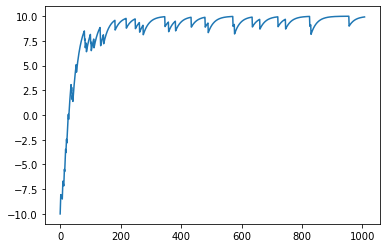

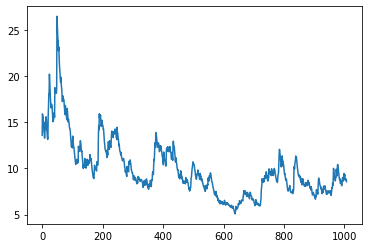

In [5]:
if __name__ == '__main__':
    world = GridWorld([4,4], [3,3], [3,3], [0,0])
    pi, v, scores, steps = REINFORCE_with_mean_baseline(world)
    print(pi.weights)
    plt.plot(scores)
    plt.show()
    plt.plot(steps)
    plt.show()